In [12]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
datadir = './data'

Populating the interactive namespace from numpy and matplotlib


# Plotting Subway Delay and Ridership Information
This notebook plots the relationship between ridership and subway delays on a per station basis for 2015.

## First, create a filter to only use Yonge-University-Spadina and Bloor-Danforth Stations

These are the two most used lines.

In [175]:
yus = ['downsview','wilson','yorkdale','lawrence west','glencairn','eglinton west','st clair west','dupont','spadina','st george','museum',"queen's park",'st patrick','osgoode','st andrew','union','king','queen','dundas','college','wellesley','bloor','rosedale','summerhill','st clair','davisville','eglinton','lawrence','york mills','sheppard','north york centre','finch']
bd = ['kipling','islington','royal york','old mill','jane','runnymede','high park','keele','dundas west','lansdowne','dufferin','ossington','christie','bathurst','spadina','st george','bay','yonge','sherbourne','castle frank','broadview','chester','pape','donlands','greenwood','coxwell','woodbine','main street','victoria park','warden','kennedy']
interchange = ['spadina','st george'] # bloor-yonge is also interchange, but it has different names on each line

## Station Map Locations

In [181]:
NS_sep = 1
EW_sep = 1

turn = yus.index('union')
US_posy = np.arange(0,(turn)*NS_sep,NS_sep)[::-1]
US_posx = -EW_sep*np.ones(len(US_posy))
Y_posy = np.arange(0,(len(yus)-turn-1)*NS_sep,NS_sep)
Y_posx = EW_sep*np.ones(len(Y_posy))
NS_posy = np.concatenate((US_posy,-NS_sep*np.ones(1)))
NS_posy = np.concatenate((NS_posy,Y_posy))
NS_posx = np.concatenate((US_posx,np.zeros(1)))
NS_posx = np.concatenate((NS_posx,Y_posx))
NS_posy[0:yus.index('spadina')] -= NS_sep
NS_posx[0:yus.index('spadina')] -= EW_sep

EW_posx = np.arange(0,len(bd)*EW_sep,EW_sep)
EW_posy = np.zeros(len(EW_posx)) + NS_posy[yus.index('spadina')]
EW_posx -= EW_posx[bd.index('bay')]

### Here's what the station map looks like

([], <a list of 0 Text yticklabel objects>)

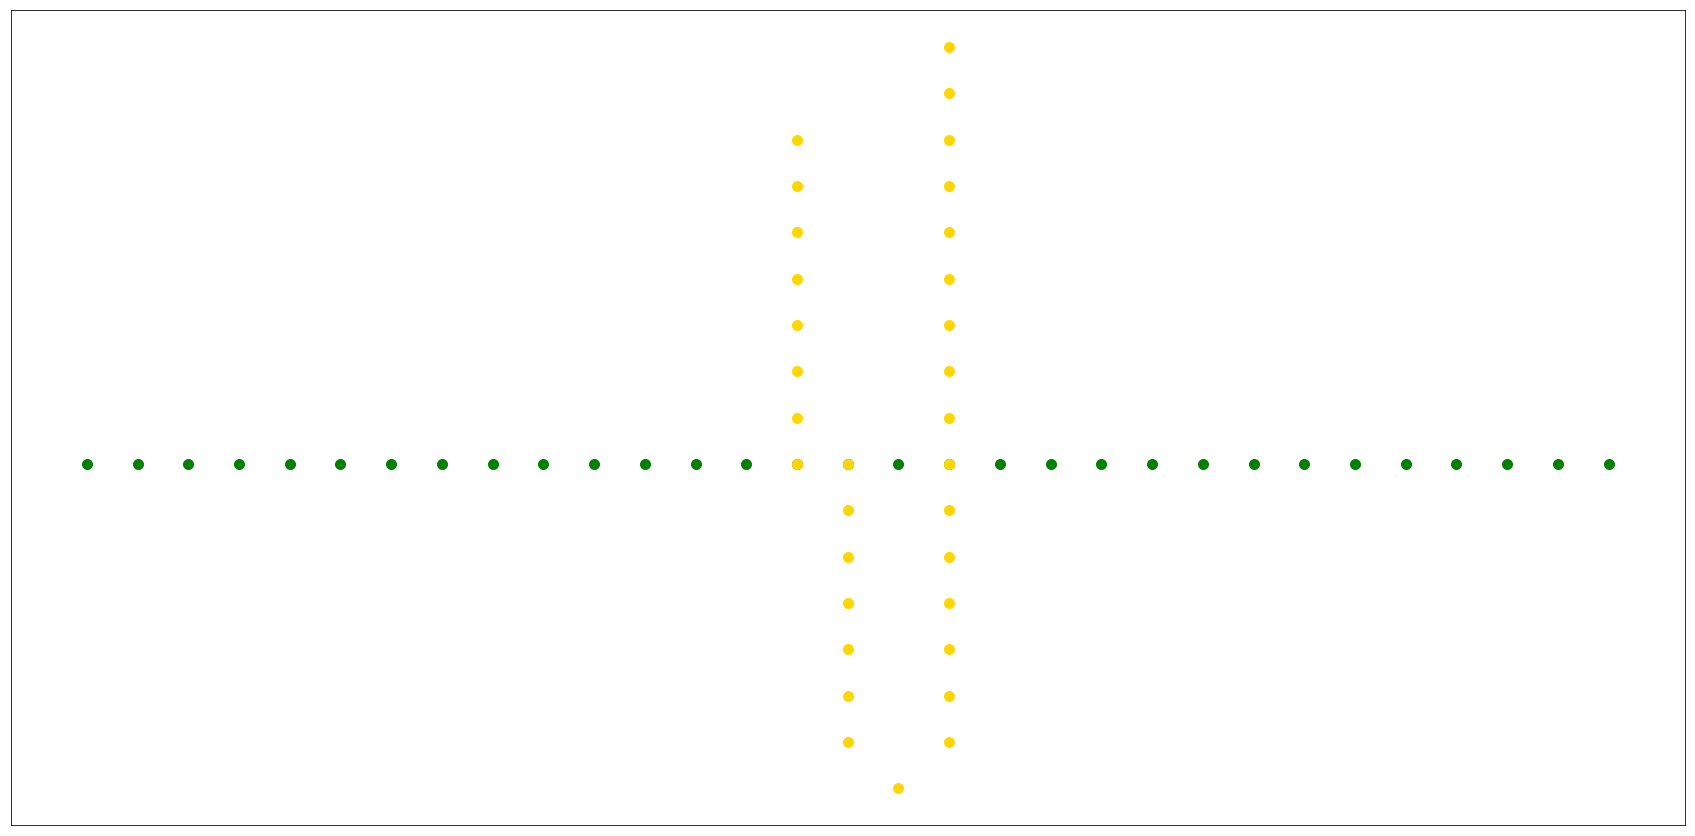

In [182]:
plt.figure(figsize=(30,15))
plt.plot(EW_posx,EW_posy,'o',color='g',markersize=10)
plt.plot(NS_posx,NS_posy,'o',color='gold',markersize=10)
plt.xticks([])
plt.yticks([])

## Import Ridership Information

In [183]:
ridership = np.loadtxt('{0}/ridership_2015.csv'.format(datadir),delimiter=',',skiprows=3,dtype=str)
station = ridership[:,1]
totrain = ridership[:,2]
fromtrain = ridership[:,3]
total = ridership[:,4]

## Import Delay Code Information

In [184]:
delayinfo = np.loadtxt('{0}/delay_codes_2014-2017.csv'.format(datadir),delimiter=',',skiprows=1,dtype='str')

# Columns: date, time, day, location, code, delay time, train gap time, train direction, line, vehicle number

# Mask for known codes and only the YUS and BD lines
mask = (delayinfo[:,8]!='SRT') & (delayinfo[:,9]!='SHP') & (delayinfo[:,4]!='XXXXX') & (delayinfo[:,4]!='XXXXXX')
delayinfo=delayinfo[mask]

In [185]:
def station_stack(stations,delayinfo,directions):
    totaldelays = np.zeros(len(stations))
    delays = {}
    loc = delayinfo[:,3]
    direc = delayinfo[:,7]
    for station in range(len(stations)):
        if stations[station] in interchange:
            delays[stations[station]] = [loc[i] for i in range(len(loc)) if ((stations[station] in (loc[i]).lower()) & (direc[i] in directions))]
            totaldelays[station] = len(delays[stations[station]])
        else:
            delays[stations[station]] = [loc[i] for i in range(len(loc)) if stations[station] in (loc[i]).lower()]
            totaldelays[station] = len(delays[stations[station]])
    return totaldelays

In [186]:
yus_delays = station_stack(yus,delayinfo,directions='NS')
bd_delays = station_stack(bd,delayinfo,directions='EW')

([], <a list of 0 Text yticklabel objects>)

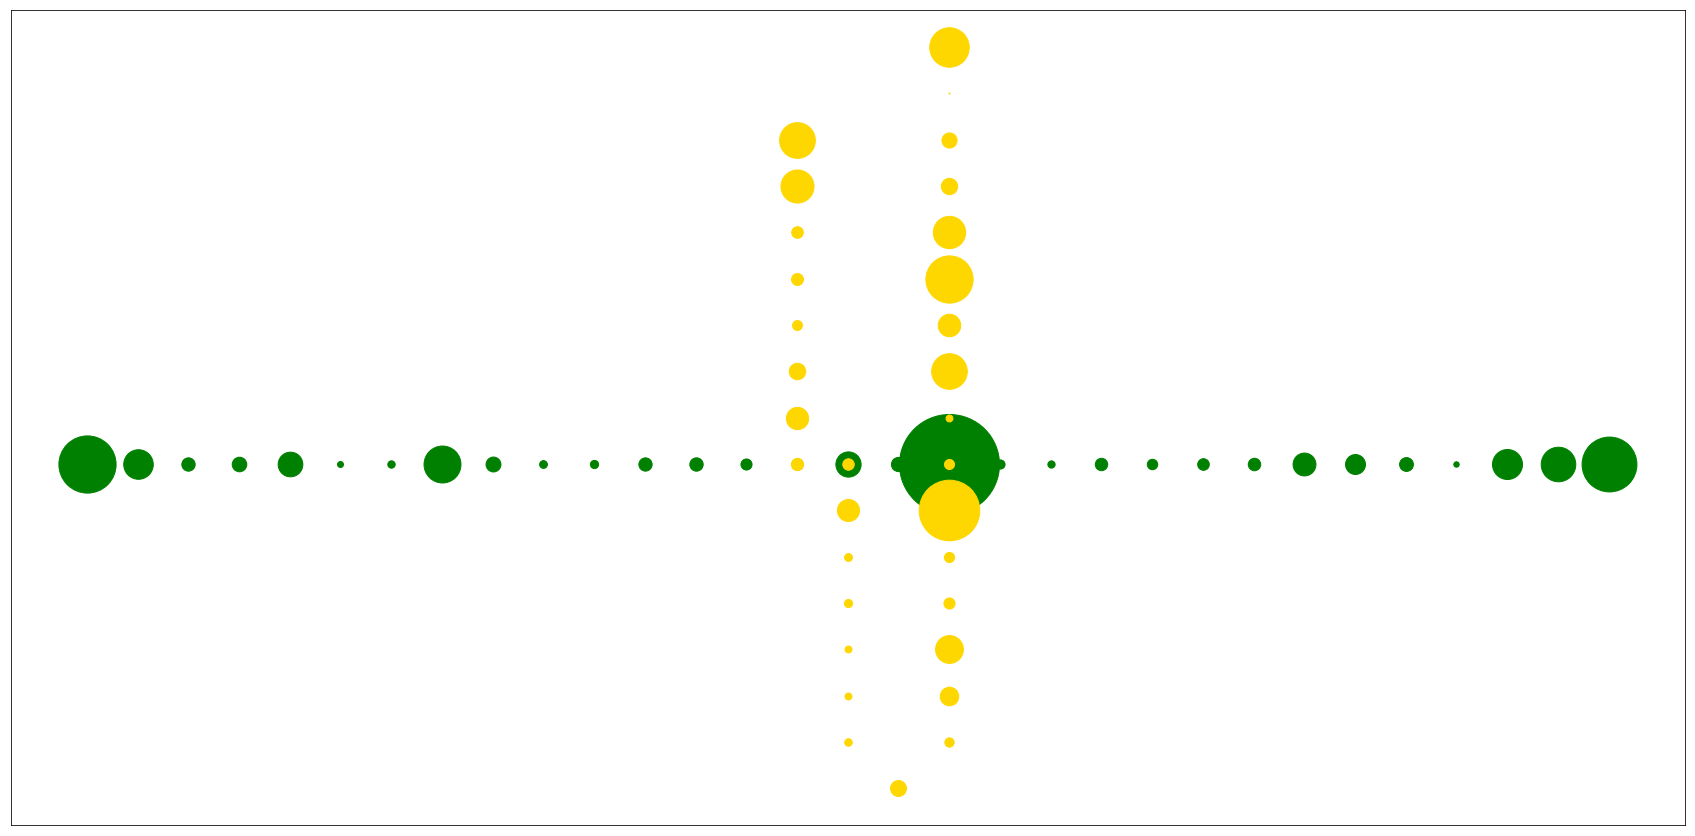

In [187]:
min_delay = np.min(np.concatenate((yus_delays,bd_delays)))
plt.figure(figsize=(30,15))
scaleddelays = bd_delays/min_delay
for station in range(len(scaleddelays)):
    plt.plot(EW_posx[station],EW_posy[station],'o',markersize=scaleddelays[station],color='g')

scaleddelays = yus_delays/min_delay
for station in range(len(scaleddelays)):
    plt.plot(NS_posx[station],NS_posy[station],'o',markersize=scaleddelays[station],color='gold')
plt.xticks([])
plt.yticks([])

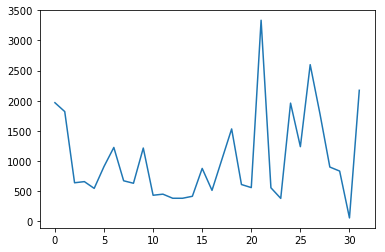

In [188]:
plt.plot(yus_delays)